# Importing libraries: 

In [17]:
import numpy as np
import pandas as pd 

# Importing Datasets

In [18]:
AS = pd.read_csv('../data/AirlineScrappedReview_Cleaned.csv')
CC = pd.read_csv('../data/Customer_comment.csv')
PB = pd.read_csv('../data/Passanger_booking_data.csv')
SS = pd.read_csv('../data/Survey data_Inflight Satisfaction Score.csv')

# Cleaning Customer Comment Dataset

In [19]:
df = AS

In [20]:
df.head()

,Passanger_Name,Flying_Date,Route,Rating,Verified,Review_title,Review_content,Traveller_Type,Class,Start_Location,End_Location,Layover_Route,Start_Latitude,Start_Longitude,Start_Address,End_Latitude,End_Longitude,End_Address
0,Paige Boet,June 2023,New Orleans to London,1,Trip Verified,The airline lost my luggage,The airline lost my luggage and was absolutely...,Solo Leisure,Economy Class,New Orleans,London,NaN,29.975998,-90.078213,"New Orleans, Orleans Parish, Louisiana, United...",51.507446,-0.127765,"London, Greater London, England, United Kingdom"
1,S Layne,March 2023,London to Amman,1,Trip Verified,fully refunded by our travel insurance,"We booked on the BA website, round trip flight...",Couple Leisure,Business Class,London,Amman,NaN,51.507446,-0.127765,"London, Greater London, England, United Kingdom",31.951569,35.923963,"عمان, ناحية عمان, لواء قصبة عمان, عمان, 11110,..."
2,E Lanewoski,NaN,Heathrow to Bodrum,2,Trip Verified,no boarding drinks provided,"First time flying with BA business class, neve...",Solo Leisure,Business Class,London Heathrow,Bodrum,NaN,51.467739,-0.458780,"London Heathrow Airport, The Beacon Roundabout...",37.034399,27.430651,"Bodrum, Muğla, Ege Bölgesi, Türkiye"
3,Joel Burman,June 2023,Amman to London,4,Not Verified,WiFi didn't work,You can buy sandwiches and crisps but don't ex...,Solo Leisure,Economy Class,Amman,London,NaN,31.951569,35.923963,"عمان, ناحية عمان, لواء قصبة عمان, عمان, 11110,...",51.507446,-0.127765,"London, Greater London, England, United Kingdom"
4,R Vines,NaN,London City to Ibiza,7,Trip Verified,stick with economy,This is a two-for-one review covering economy ...,Family Leisure,Business Class,London City,Ibiza,NaN,42.953765,-81.229153,"London (city), Ontario, N6C 0A7, Canada",38.974390,1.419746,"Eivissa, Illes Balears, España"


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3575 entries, 0 to 3574
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Passanger_Name   3574 non-null   object 
 1   Flying_Date      955 non-null    object 
 2   Route            2809 non-null   object 
 3   Rating           3575 non-null   int64  
 4   Verified         3575 non-null   object 
 5   Review_title     3575 non-null   object 
 6   Review_content   3575 non-null   object 
 7   Traveller_Type   3575 non-null   object 
 8   Class            3575 non-null   object 
 9   Start_Location   2809 non-null   object 
 10  End_Location     2809 non-null   object 
 11  Layover_Route    484 non-null    object 
 12  Start_Latitude   3515 non-null   float64
 13  Start_Longitude  3515 non-null   float64
 14  Start_Address    3515 non-null   object 
 15  End_Latitude     3476 non-null   float64
 16  End_Longitude    3476 non-null   float64
 17  End_Address   

In [22]:
df.describe()

,Rating,Start_Latitude,Start_Longitude,End_Latitude,End_Longitude
count,3575.000000,3515.000000,3515.000000,3476.000000,3476.000000
mean,4.790490,42.639473,-2.164986,40.550399,-1.118816
std,3.170323,17.022014,44.576587,18.723619,46.045735
min,1.000000,-37.666951,-123.182909,-37.814245,-123.179234
25%,2.000000,41.893320,-0.458780,39.739236,-0.458780
50%,4.000000,46.314475,-0.127765,46.314475,-0.127765
75%,8.000000,51.467739,11.048029,51.467739,11.048029
max,10.000000,65.011873,151.208285,64.145981,174.550610


In [23]:
df.isnull().sum()

Passanger_Name        1
Flying_Date        2620
Route               766
Rating                0
Verified              0
Review_title          0
Review_content        0
Traveller_Type        0
Class                 0
Start_Location      766
End_Location        766
Layover_Route      3091
Start_Latitude       60
Start_Longitude      60
Start_Address        60
End_Latitude         99
End_Longitude        99
End_Address          99
dtype: int64

<Axes: >

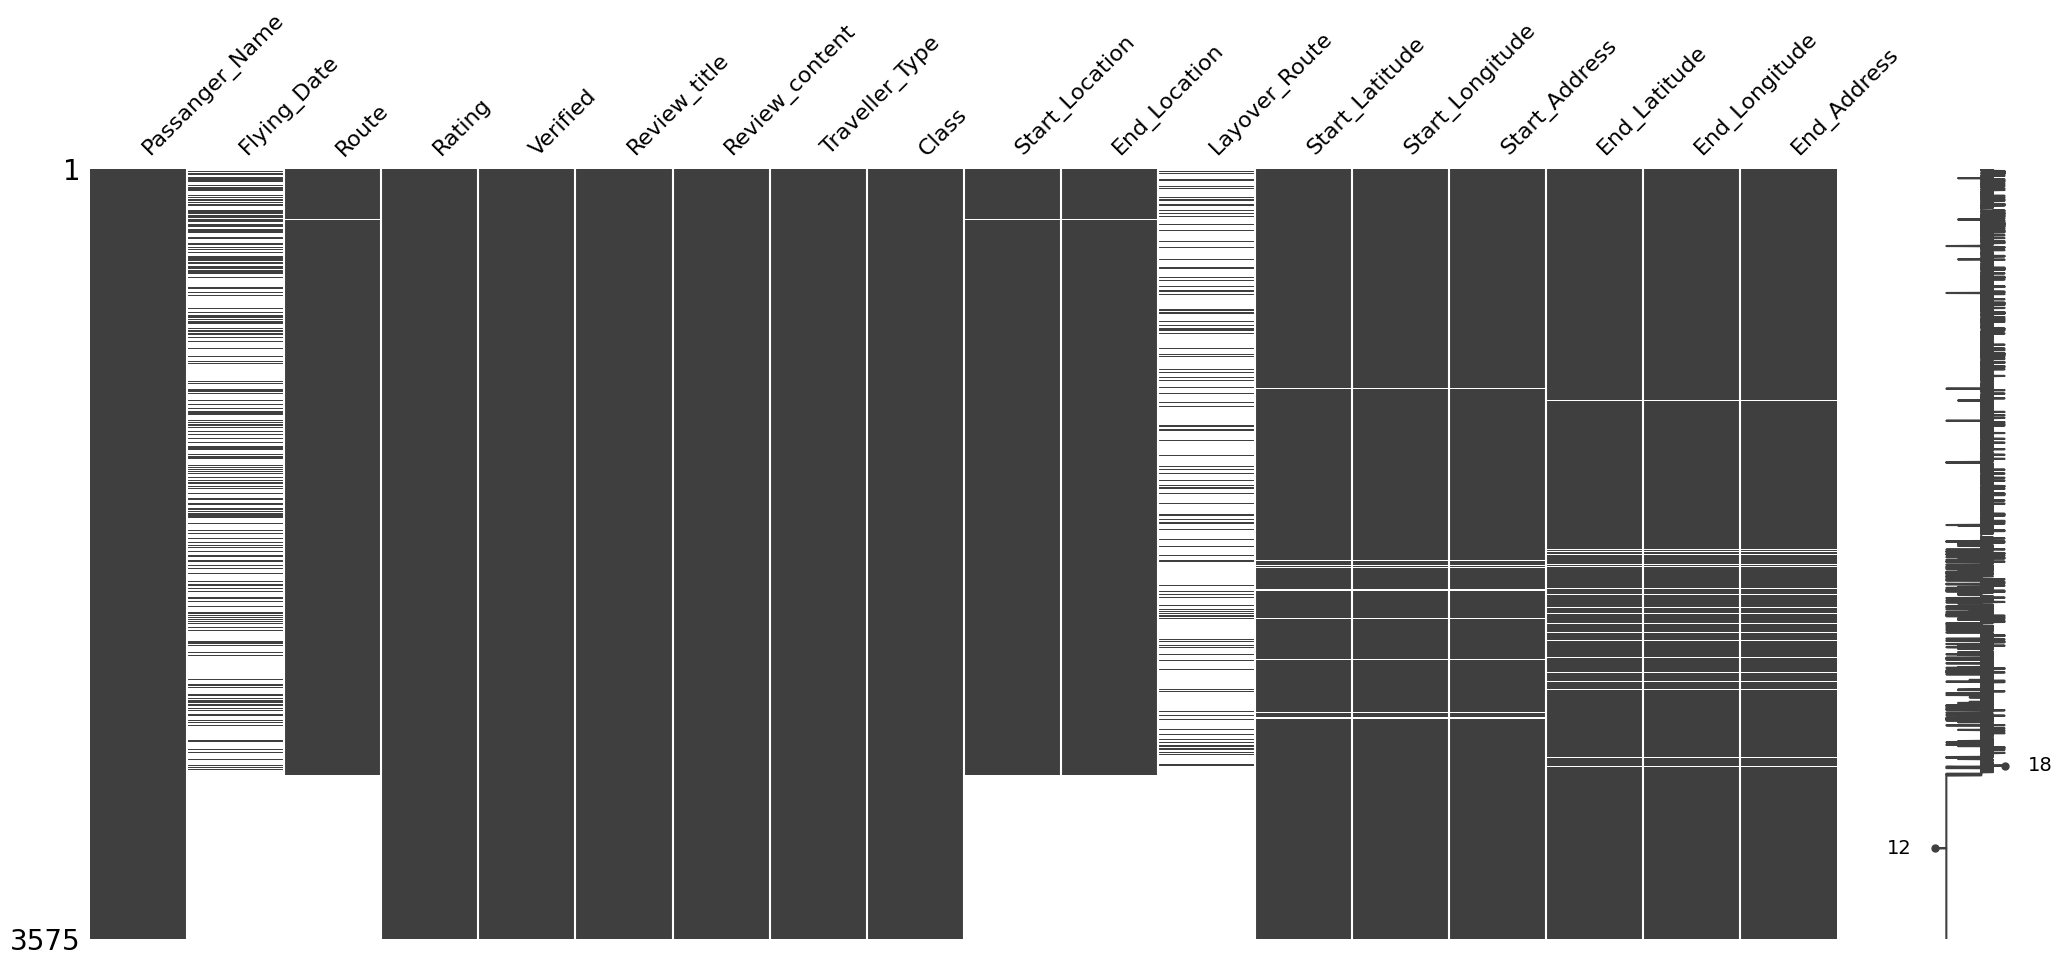

In [24]:

import missingno as msno
msno.matrix(df)

In [25]:
#df = df.drop(columns=['Unnamed'])
#df['loyalty_program_level'] = df['loyalty_program_level'].fillna(df['loyalty_program_level'].mode()[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9424 entries, 0 to 9423
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                9424 non-null   int64 
 1   flight_number             9424 non-null   int64 
 2   origin_station_code       9424 non-null   object
 3   destination_station_code  9424 non-null   object
 4   scheduled_departure_date  9424 non-null   object
 5   arrival_delay_group       9424 non-null   object
 6   departure_delay_group     9424 non-null   object
 7   entity                    9424 non-null   object
 8   verbatim_text             9424 non-null   object
 9   seat_factor_band          9424 non-null   object
 10  ques_verbatim_text        9424 non-null   object
 11  loyalty_program_level     6920 non-null   object
 12  fleet_type_description    9424 non-null   object
 13  fleet_usage               9424 non-null   object
 14  response_group          

<Axes: >

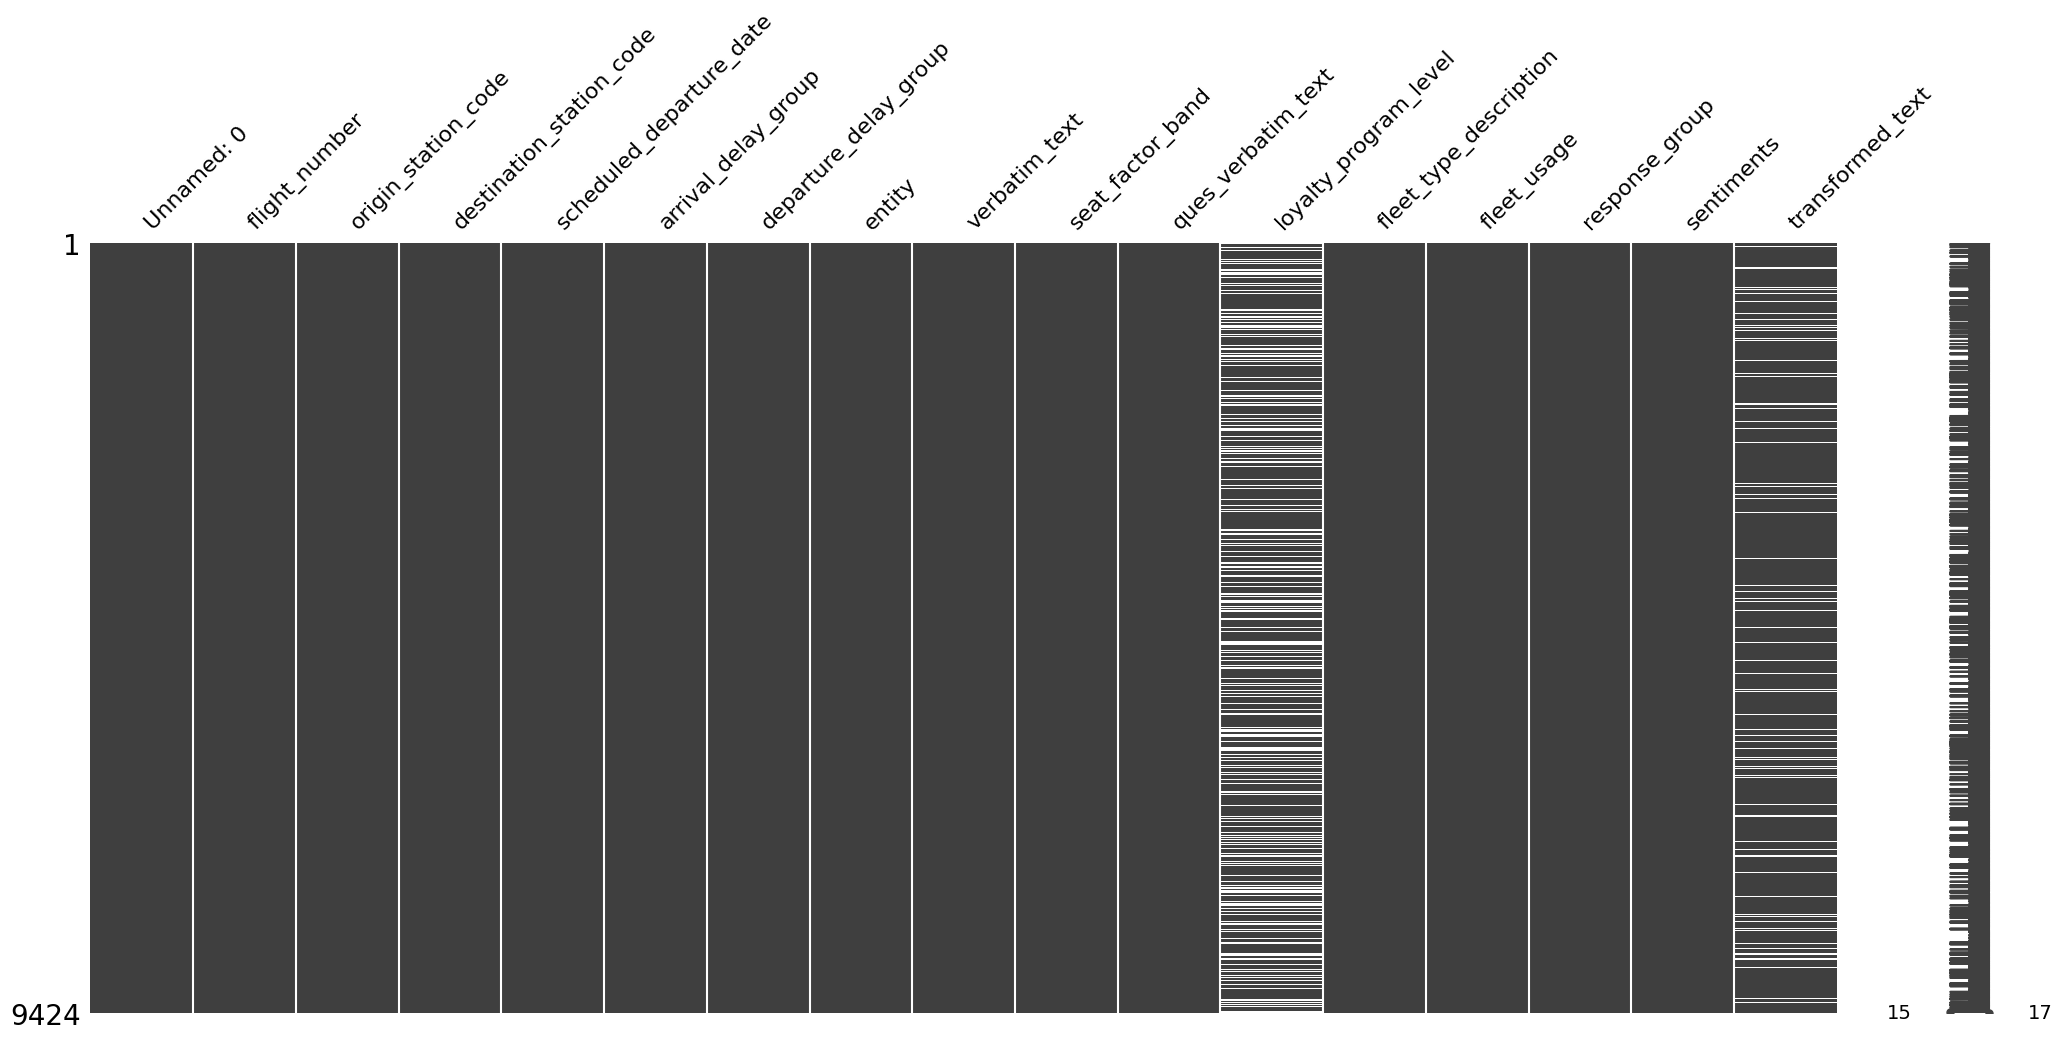

In [26]:
df = CC

df.info()
df.describe()
df.isnull().sum()
import missingno as msno
msno.matrix(df)

Balls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50002 entries, 0 to 50001
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50002 non-null  int64  
 1   sales_channel          50002 non-null  object 
 2   trip_type              50002 non-null  object 
 3   purchase_lead          50002 non-null  int64  
 4   length_of_stay         50002 non-null  int64  
 5   flight_hour            50002 non-null  int64  
 6   flight_day             50002 non-null  object 
 7   route                  50002 non-null  object 
 8   booking_origin         50002 non-null  object 
 9   wants_extra_baggage    50002 non-null  int64  
 10  wants_preferred_seat   50002 non-null  int64  
 11  wants_in_flight_meals  50002 non-null  int64  
 12  flight_duration        50002 non-null  float64
 13  booking_complete       50002 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

<Axes: >

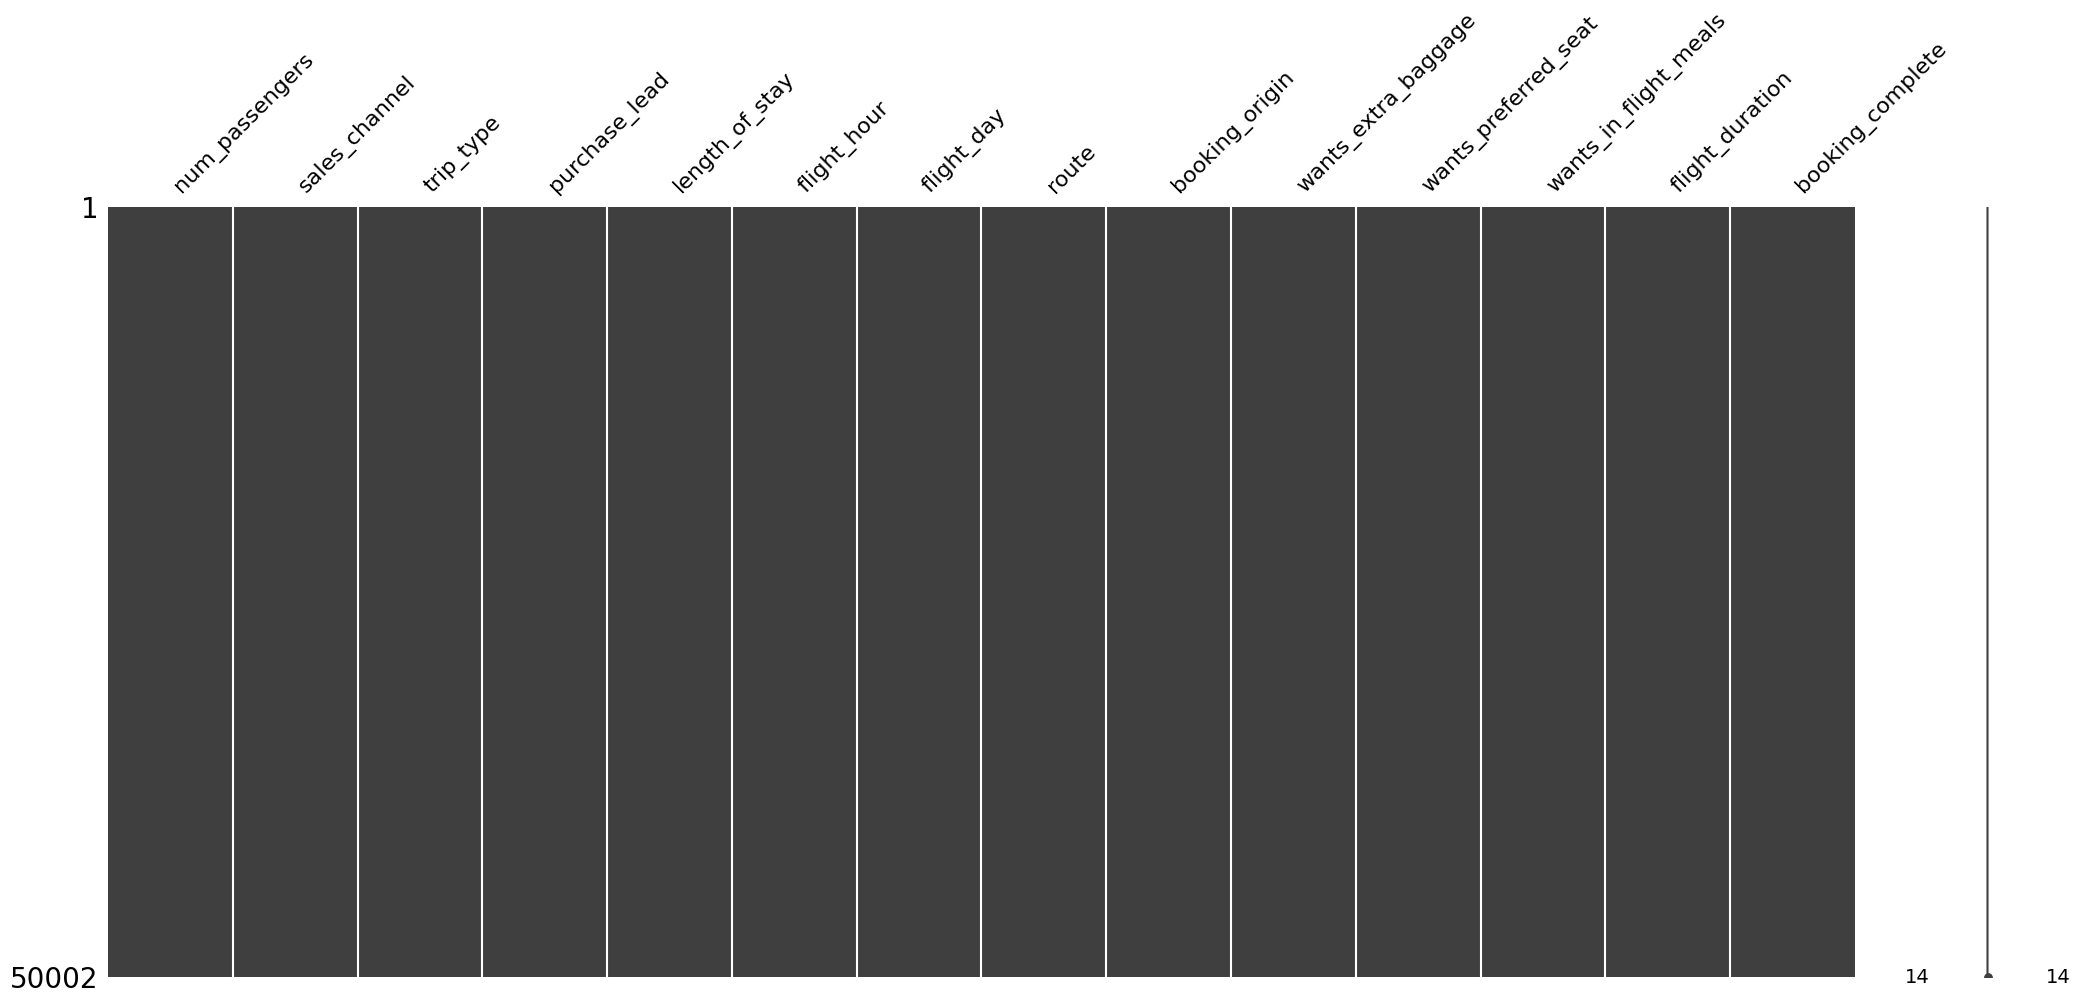

In [27]:
df = PB

df.info()
df.describe()
df.isnull().sum()
import missingno as msno
msno.matrix(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47074 entries, 0 to 47073
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   flight_number                     47074 non-null  int64 
 1   origin_station_code               47074 non-null  object
 2   destination_station_code          47074 non-null  object
 3   record_locator                    47074 non-null  object
 4   scheduled_departure_date          47074 non-null  object
 5   question_text                     47074 non-null  object
 6   score                             47074 non-null  object
 7   satisfaction_type                 34963 non-null  object
 8   driver_sub_group1                 47074 non-null  object
 9   driver_sub_group2                 47074 non-null  object
 10  arrival_delay_minutes             47074 non-null  int64 
 11  arrival_delay_group               47074 non-null  object
 12  cabin_code_desc   

<Axes: >

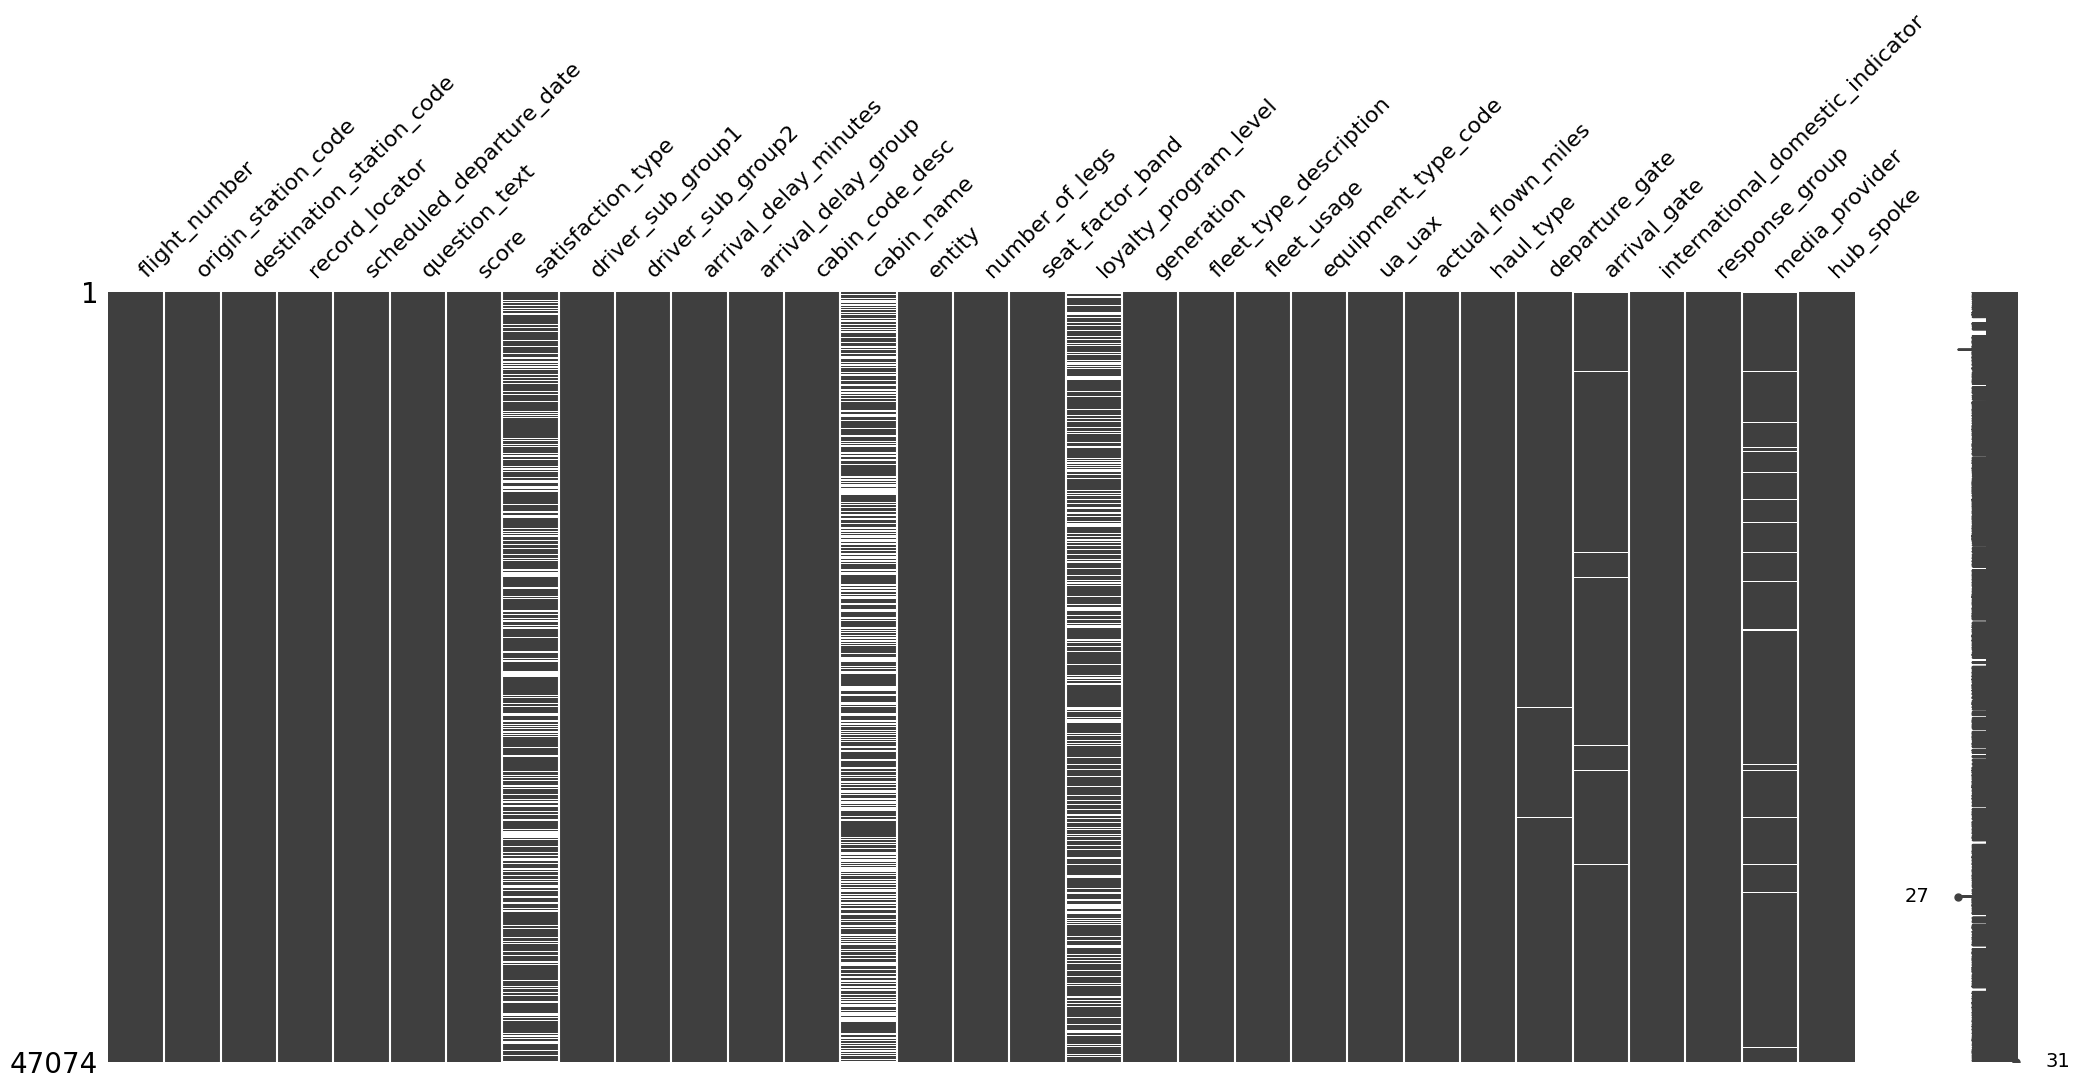

In [28]:
df = SS

df.info()
df.describe()
df.isnull().sum()
import missingno as msno
msno.matrix(df)